# Search for Parameters That Maximize the Hill Number

This notebook utilizes the solution to the reaction scheme matrix, obtained from the "solve_EA2B_matrix" script.

It randomly generates a million sets of rate constants.

For each parameter set, the reaction velocity is calculated against the concentration of ligand A and fitted to the Hill equation to analyze the cooperative behavior.

## 01 imports and initial setup

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool 
import sympy as sp
from sympy import symbols


In [2]:

# Hill equation
def hill_eq(X, vmax, Kd, n):
    return (vmax * X**n) / (Kd**n + X**n)


A_vals = np.linspace(0.1, 2000, 1000)  # Avoid division by zero by starting at 0.1

# Storage for maximum Hill coefficients
max_hill_parameters = []



# Preallocate for tracking the best Hill coefficient
max_hill = 1;
max_vmax = 0;
best_fit_params = [];

best_fit_data = {}  
iterations_data = []

# A function to calculate fit quality metrics
def compute_fit_metrics(A_vals, V_vals, fit_params):
    predicted_vals = hill_eq(A_vals, *fit_params)
    residuals = V_vals - predicted_vals
    RSS = np.sum(residuals**2)  # Residual Sum of Squares
    TSS = np.sum((V_vals - np.mean(V_vals))**2)  # Total Sum of Squares
    R_squared = 1 - (RSS / TSS) if TSS > 0 else 0
    return RSS, R_squared

## 02 Set parameter values for testing

In [3]:

a = 1;
b = 0.1; # controlles internal hill value (low b creates high hill)
B = 100; # concentration of the second substrate
ET = 0.1; #total concentration of the enzyme

bound = 1e10  # A large number to approximate infinity
param_bounds = {
"k1"   :      (0,bound),
"k_1"  :      (0,bound),
"k_2"  :      (0,bound),
"k3"   :      (0,bound),
"k_3"  :      (0,bound),
"k_4"  :      (0,bound),
"k5"   :      (0,bound),
"k_5"  :      (0,bound),
"k6"   :      (0,bound),
"k_6"  :      (0,bound),
"k7"   :      (0,bound),
"B"    :        1.0e+02,
"ET"   :        1.0e-01,
"a"    :              1,
"b"    :            0.1,

}
    

# Vectorized sampling
num_samples = 1000000

# Separate fixed and sampled bounds
fixed_params = {}
sampled_bounds = {}

for key, val in param_bounds.items():
    if isinstance(val, tuple):
        sampled_bounds[key] = val
    else:
        fixed_params[key] = np.full(num_samples, val)  # Repeat fixed value across all samples

# Sample only the ones with ranges
sampled_params = {key: np.random.uniform(low, high, num_samples) for key, (low, high) in sampled_bounds.items()}

# Combine both
params = {**sampled_params, **fixed_params}


## 03 Coefficient calculations

In [4]:
  


P1 = params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**3*params['k_1']**3*params['k_5']**2

P2 = params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**2

P3 = params['B']**3*params['ET']*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6']

P4 = params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**3*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**3*params['k_1']**3*params['k_5']**3

P5 = params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['B']*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**4*params['k_5']**2 + params['b']**3*params['k1']*params['k3']**2*params['k6']**3*params['k_1']**4*params['k_5']**3

P6 = params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']**2*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**4*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**4*params['k_4']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']*params['k6']**3*params['k7']*params['k_1']**4*params['k_2']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**3*params['k_1']**4*params['k_2']*params['k_5']**3 + params['b']**3*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**5*params['k_5']**2 + params['b']**3*params['k3']**2*params['k6']**3*params['k_1']**5*params['k_5']**3

P7 = params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k7']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k_2']*params['k_3']*params['k_4']*params['k_6']**3 + params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k6']*params['k7']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**3 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**4*params['k_2']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**5*params['k_4']*params['k_5']**2 + params['b']**3*params['k3']**2*params['k6']**2*params['k_1']**5*params['k_4']*params['k_5']**3 + params['b']**3*params['k3']**2*params['k6']**2*params['k_1']**5*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**3*params['k7']*params['k_1']**5*params['k_2']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**3*params['k_1']**5*params['k_2']*params['k_5']**3

P8 = params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k7']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**2 + params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**3 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**3 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**2*params['k7']*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**2*params['k7']*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**3 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**3 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**2*params['k_6']








## 04 Equation calculation

In [5]:


A_vals = np.array(A_vals)


V_vals = (
    P1[:, None] * A_vals**4 +
     P2[:, None] * A_vals**3 +
     P3[:, None] * A_vals**2 
) / (
    P4[:, None] * A_vals**4 +
     P5[:, None] * A_vals**3 +
     P6[:, None] * A_vals**2 +
     P7[:, None] * A_vals +
     P8[:, None]
)





## 05 Fit Hill equation for one sample of set of parameters

In [6]:

def fit_sample(sample_data):
    A_vals, V_sample, idx = sample_data
    
    # Initial guess for Hill parameters
    hill_params_guess = [np.max(V_sample), np.median(A_vals), 1]
    
    try:
        # Fit Hill equation
        fit_params, _ = curve_fit(hill_eq, A_vals, V_sample, p0=hill_params_guess)
        vmax_fit, Kd_fit, n_fit = fit_params
        
        # Compute fit quality metrics
        RSS, R_squared = compute_fit_metrics(A_vals, V_sample, fit_params)
        
        # Return fit results and metrics
        return {
            "Iteration": idx,
            "vmax_fit": vmax_fit,
            "Kd_fit": Kd_fit,
            "n_fit": n_fit,
            "RSS": RSS,
            "R_squared": R_squared
        }
    except RuntimeError as e:
        return {
        }

# Prepare data for parallel processing
samples_data = [(A_vals, V_vals[i, :], i) for i in range(V_vals.shape[0])]

# Use multiprocessing for parallel fitting
with Pool() as pool:
    results = pool.map(fit_sample, samples_data)



/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)
/tmp/ipykernel_2030580/2652376705.

## 06 Convert results to a DataFrame and filter by quality of the fit

In [15]:

results_df = pd.DataFrame(results)
params_df = pd.DataFrame(params)
results_df = pd.concat([results_df, params_df], axis=1)


In [16]:
columns_order = ["Iteration", "n_fit", "RSS", "R_squared", "vmax_fit", "Kd_fit", 
                 "k1", "k_1", "k_2", "k3", "k_3", "k_4", "k5", "k_5", "k6", "k_6", "k7", "a", "b", "B", "ET"]
results_df = results_df[columns_order]
results_df.set_index("Iteration", inplace=True) 

#filltering options
results_df_filltered = results_df[results_df['R_squared'] >= 0.99].copy()
results_df_filltered = results_df_filltered[results_df_filltered['RSS'] <= 1e-10].copy()
#aditional options
results_df_filltered = results_df_filltered[results_df_filltered['Kd_fit'] <= 100].copy()
results_df_filltered = results_df_filltered[results_df_filltered['vmax_fit'] >= 0.001].copy()

#Sorting by 'n_fit'
results_df_filltered.sort_values(by="n_fit", ascending=False, inplace=True)

results_df_filltered.head(200)
#results_df_filltered.head(200).to_csv('path_to_desired_location.csv', index=False)


,n_fit,RSS,R_squared,vmax_fit,Kd_fit,k1,k_1,k_2,k3,k_3,k_4,k5,k_5,k6,k_6,k7,a,b,B,ET
Iteration,,,,,,,,,,,,,,,,,,,,
801140.0,1.940141,7.671058e-12,0.999997,0.001929,0.299796,3.581397e+09,3.218453e+09,9.331728e+09,8.107835e+09,4.594545e+09,1.761358e+09,7.094853e+05,2.897494e+09,9.825888e+09,3.931974e+09,7.092365e+08,1,0.1,100.0,0.1
775931.0,1.933231,1.641833e-11,0.999997,0.002619,0.407365,6.758363e+09,5.660312e+09,1.825768e+09,1.309569e+09,7.975956e+09,1.929050e+08,3.562137e+06,5.251952e+09,9.002325e+09,1.245366e+09,7.994453e+09,1,0.1,100.0,0.1
322090.0,1.882849,5.218166e-11,0.999982,0.001663,1.149937,1.249875e+09,3.881725e+09,5.992102e+08,7.918439e+09,2.313137e+09,6.887977e+09,2.718861e+06,8.607828e+09,8.074390e+09,7.027344e+09,7.466835e+09,1,0.1,100.0,0.1
135522.0,1.855236,7.471068e-12,0.999994,0.001075,1.394397,8.450129e+08,3.640098e+09,3.785458e+09,7.057537e+09,1.331350e+09,1.925369e+09,1.549860e+06,5.189222e+09,5.010838e+09,9.895435e+09,9.071249e+09,1,0.1,100.0,0.1
607542.0,1.844510,1.766786e-11,0.999993,0.001552,0.823422,3.318462e+09,7.409112e+09,7.948590e+09,5.626806e+09,5.973898e+09,6.640925e+09,2.472473e+06,9.403937e+09,4.996655e+09,3.075902e+09,6.275618e+09,1,0.1,100.0,0.1
912229.0,1.837489,2.311983e-11,0.999997,0.002258,2.835527,7.924675e+08,6.736609e+09,3.045169e+09,2.651365e+09,8.105327e+09,8.533760e+09,2.695299e+06,6.529290e+09,5.057827e+09,6.865877e+09,5.136958e+09,1,0.1,100.0,0.1
792975.0,1.775989,2.922220e-12,0.999999,0.002567,0.443665,1.939094e+09,1.995120e+09,2.203244e+09,2.402551e+09,2.892289e+09,6.415919e+09,2.646610e+06,8.659811e+09,5.406324e+09,2.837559e+09,1.386604e+09,1,0.1,100.0,0.1
835307.0,1.721887,9.885617e-12,0.999996,0.001893,0.247595,8.335405e+09,4.597902e+09,8.210285e+09,2.359061e+09,1.765594e+09,7.132444e+09,3.303264e+06,9.284295e+09,9.969897e+09,9.894614e+08,7.835302e+09,1,0.1,100.0,0.1
596145.0,1.689558,3.932248e-11,0.999987,0.002461,0.163698,5.676290e+09,1.894838e+09,3.502657e+09,6.726860e+09,7.412105e+09,5.103619e+09,2.556081e+06,7.490951e+09,3.974213e+09,2.784990e+08,2.638652e+09,1,0.1,100.0,0.1


In [17]:
#statistics of the results
results_df.describe()


,n_fit,RSS,R_squared,vmax_fit,Kd_fit,k1,k_1,k_2,k3,k_3,k_4,k5,k_5,k6,k_6,k7,a,b,B,ET
count,991141.000000,9.911410e+05,991141.000000,991141.000000,9.911410e+05,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1000000.0,1.000000e+06,1000000.0,1.000000e+06
mean,1.103746,9.014118e-05,0.994560,0.285241,1.000823e+09,5.000692e+09,5.006395e+09,4.998113e+09,5.002225e+09,4.999459e+09,5.003653e+09,5.005693e+09,4.995693e+09,5.000120e+09,5.000952e+09,4.999341e+09,1.0,1.000000e-01,100.0,1.000000e-01
std,0.187906,7.152340e-04,0.046744,187.718573,4.014373e+11,2.888250e+09,2.887720e+09,2.886550e+09,2.885253e+09,2.883571e+09,2.886499e+09,2.888249e+09,2.886688e+09,2.887028e+09,2.887340e+09,2.885310e+09,0.0,1.332879e-12,0.0,1.332879e-12
min,-2.031122,1.570339e-16,0.000002,0.000009,1.639709e-27,8.198446e+03,2.742323e+03,6.758974e+02,2.591942e+03,1.178566e+04,1.238805e+04,9.132086e+03,1.208214e+03,1.698813e+03,6.752004e+03,6.082469e+03,1.0,1.000000e-01,100.0,1.000000e-01
25%,1.042311,7.315824e-06,0.998863,0.097192,2.668416e+00,2.499084e+09,2.504082e+09,2.498432e+09,2.503753e+09,2.504171e+09,2.504569e+09,2.503500e+09,2.491734e+09,2.499183e+09,2.502135e+09,2.501472e+09,1.0,1.000000e-01,100.0,1.000000e-01
50%,1.090258,1.293838e-05,0.999434,0.098621,4.466278e+00,5.001315e+09,5.009131e+09,4.996493e+09,5.002358e+09,5.001462e+09,5.010656e+09,5.009007e+09,4.994940e+09,4.999207e+09,4.998801e+09,4.997892e+09,1.0,1.000000e-01,100.0,1.000000e-01
75%,1.153881,2.816908e-05,0.999729,0.099254,8.876126e+00,7.500886e+09,7.508024e+09,7.495573e+09,7.500793e+09,7.496113e+09,7.502653e+09,7.510078e+09,7.494630e+09,7.499394e+09,7.500341e+09,7.498462e+09,1.0,1.000000e-01,100.0,1.000000e-01
max,21.967370,4.454745e-02,1.000000,186885.320658,2.903713e+14,9.999989e+09,9.999995e+09,9.999998e+09,9.999994e+09,9.999999e+09,9.999999e+09,9.999998e+09,9.999979e+09,9.999977e+09,9.999995e+09,9.999999e+09,1.0,1.000000e-01,100.0,1.000000e-01


## 07 examine individual set of parameters by iteration number

/tmp/ipykernel_2030580/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)


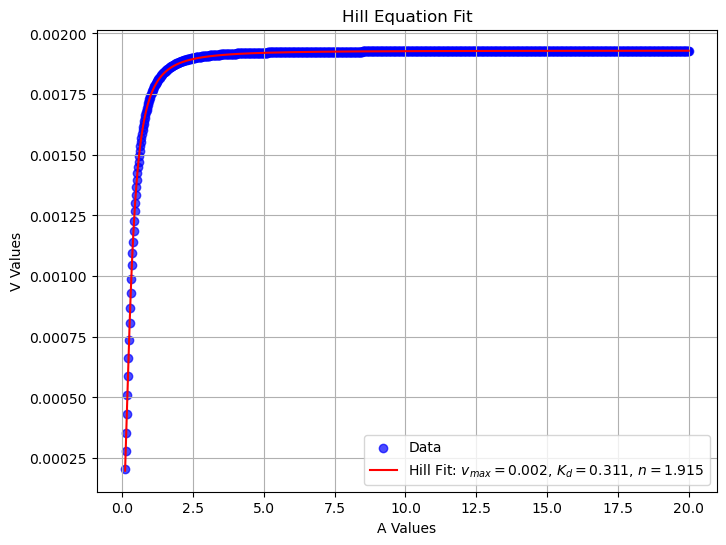

vmax_fit: 0.002
Kd_fit: 0.311
n_fit: 1.915
k1     3.581397e+09
k_1    3.218453e+09
k_2    9.331728e+09
k3     8.107835e+09
k_3    4.594545e+09
k_4    1.761358e+09
k5     7.094853e+05
k_5    2.897494e+09
k6     9.825888e+09
k_6    3.931974e+09
k7     7.092365e+08
Name: 801140.0, dtype: float64


In [14]:
#looking into the quality of the fit by the iteration number

A_vals_2= np.linspace(0.1, 20, 1000)  
iteration_dat = results_df_filltered.loc[801140.0] #number of iteration you wish to inspect (1 is an example)



# Definition of all symbols
A, B, ET, a, b = symbols('A B ET a b')
k1, k3, k5, k6 = symbols('k1 k3 k5 k6')
k_1, k_2, k_3, k_4, k_5, k_6 = symbols('k_1 k_2 k_3 k_4 k_5 k_6')

k_symbols = {}
for i in range(1, 9):  
    k_symbols[f'k{i}'] = symbols(f'k{i}')
    k_symbols[f'k_{i}'] = symbols(f'k_{i}')

locals().update(k_symbols)


# Parameters calculations
for param in iteration_dat.index:
    globals()[param] = iteration_dat[param]

    
    P1 = B*ET*a*b**2*k1**2*k3**2*k5*k6**3*k_1**3*k_5**2
    P2 = (B**2*ET*a**2*b*k1**3*k3*k5**2*k6**2*k_1*k_2*k_3*k_5*k_6 + B**2*ET*a*b*k1**2*k3**2*k5**2*k6**2*k_1**2*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5**2 + B*ET*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**3*k_1**3*k_2*k_5**2)
    P3 = (B**3*ET*a**2*k1**3*k3*k5**3*k6*k_2*k_3*k_4*k_6**2 + B**2*ET*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*ET*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_6**2 + B**2*ET*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_3*k_5*k_6 + B**2*ET*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5*k_6)
    P4 = (B*a*b**2*k1**2*k3**2*k5*k6**3*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**3*k7*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**3*k_1**3*k_5**3)
    P5 = (B**2*a**2*b*k1**3*k3*k5**2*k6**2*k_1*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3**2*k5**2*k6**2*k_1**2*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6**2*k_1*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5**2 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**3*k_1**3*k_2*k_5**2 + B*a*b**2*k1*k3**2*k5*k6**3*k7*k_1**3*k_5**2 + B*a*b*k1**2*k3**2*k5*k6**2*k_1**2*k_4*k_5**2*k_6 + B*b**2*k1*k3**2*k5*k6**3*k7*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**2*k7*k_1**3*k_4*k_5**2 + a*b**2*k1**2*k3**2*k6**2*k_1**3*k_4*k_5**3 + a*b**2*k1**2*k3**2*k6**2*k_1**3*k_4*k_5**2*k_6 + a*b**2*k1**2*k3*k6**3*k7*k_1**3*k_2*k_5**2 + a*b**2*k1**2*k3*k6**3*k_1**3*k_2*k_5**3 + b**3*k1*k3**2*k6**3*k7*k_1**4*k_5**2 + b**3*k1*k3**2*k6**3*k_1**4*k_5**3)
    P6 = (B**3*a**2*k1**3*k3*k5**3*k6*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k6*k7*k_1*k_2*k_3*k_5*k_6 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_5*k_6**2 + B**2*a**2*b*k1**3*k5**2*k6**2*k7*k_1*k_2*k_3*k_5*k_6 + B**2*a**2*k1**3*k3*k5**2*k6*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3**2*k5**2*k6*k7*k_1**2*k_4*k_5*k_6 + B**2*a*b*k1**2*k3**2*k5**2*k6*k_1**2*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_4*k_5*k_6 + B**2*a*b*k1*k3**2*k5**2*k6**2*k7*k_1**2*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6*k_1*k_2*k_3*k_4*k_5**2*k_6 + B*a**2*b*k1**3*k3*k5*k6*k_1*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3**2*k5*k6*k7*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3**2*k5*k6*k_1**3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3**2*k5*k6*k_1**3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**2*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5**2 + B*a*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6**3*k7*k_1**3*k_2*k_5**2 + B*a*b*k1**2*k3*k5*k6**2*k_1**2*k_2*k_3*k_5**2*k_6 + B*a*b*k1**2*k3*k5*k6**2*k_1**2*k_2*k_4*k_5**2*k_6 + B*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5**2 + B*b**2*k1*k3**2*k5*k6**2*k_1**3*k_4*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**3*k7*k_1**3*k_2*k_5**2 + B*b**2*k3**2*k5*k6**3*k7*k_1**4*k_5**2 + a*b**2*k1**2*k3*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + a*b**2*k1**2*k3*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_3*k_5**3 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_4*k_5**3 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_4*k_5**2*k_6 + b**3*k1*k3**2*k6**2*k7*k_1**4*k_4*k_5**2 + b**3*k1*k3**2*k6**2*k_1**4*k_4*k_5**3 + b**3*k1*k3**2*k6**2*k_1**4*k_4*k_5**2*k_6 + b**3*k1*k3*k6**3*k7*k_1**4*k_2*k_5**2 + b**3*k1*k3*k6**3*k_1**4*k_2*k_5**3 + b**3*k3**2*k6**3*k7*k_1**5*k_5**2 + b**3*k3**2*k6**3*k_1**5*k_5**3)
    P7 = (B**3*a**2*k1**3*k3*k5**3*k7*k_2*k_3*k_4*k_6**2 + B**3*a**2*k1**3*k3*k5**3*k_2*k_3*k_4*k_6**3 + B**3*a**2*k1**3*k5**3*k6*k7*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k7*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k_1*k_2*k_3*k_4*k_5*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k_1*k_2*k_3*k_4*k_6**3 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3**2*k_5*k_6 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k5**2*k6*k_1*k_2*k_3**2*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_2*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_2*k_3*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_2*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k5**2*k6**2*k7*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1*k3*k5**2*k6**2*k7*k_1**2*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_3*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**2*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6**2*k7*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + B*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + B*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2*k_6 + B*b**2*k3**2*k5*k6**2*k7*k_1**4*k_4*k_5**2 + B*b**2*k3**2*k5*k6**2*k_1**4*k_4*k_5**2*k_6 + B*b**2*k3*k5*k6**3*k7*k_1**4*k_2*k_5**2 + b**3*k1*k3*k6**2*k7*k_1**4*k_2*k_3*k_5**2 + b**3*k1*k3*k6**2*k7*k_1**4*k_2*k_4*k_5**2 + b**3*k1*k3*k6**2*k_1**4*k_2*k_3*k_5**3 + b**3*k1*k3*k6**2*k_1**4*k_2*k_3*k_5**2*k_6 + b**3*k1*k3*k6**2*k_1**4*k_2*k_4*k_5**3 + b**3*k1*k3*k6**2*k_1**4*k_2*k_4*k_5**2*k_6 + b**3*k3**2*k6**2*k7*k_1**5*k_4*k_5**2 + b**3*k3**2*k6**2*k_1**5*k_4*k_5**3 + b**3*k3**2*k6**2*k_1**5*k_4*k_5**2*k_6 + b**3*k3*k6**3*k7*k_1**5*k_2*k_5**2 + b**3*k3*k6**3*k_1**5*k_2*k_5**3)
    P8 = B**3*a**2*k1**3*k5**3*k7*k_2*k_3**2*k_4*k_6**2 + B**3*a**2*k1**3*k5**3*k_2*k_3**2*k_4*k_6**3 + B**2*a**2*b*k1**3*k5**2*k7*k_1*k_2*k_3**2*k_4*k_6**2 + B**2*a**2*b*k1**3*k5**2*k_1*k_2*k_3**2*k_4*k_5*k_6**2 + B**2*a**2*b*k1**3*k5**2*k_1*k_2*k_3**2*k_4*k_6**3 + B**2*a*b*k1**2*k5**2*k6*k7*k_1**2*k_2*k_3**2*k_5*k_6 + B**2*a*b*k1**2*k5**2*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k5**2*k6*k_1**2*k_2*k_3**2*k_5*k_6**2 + B**2*a*b*k1**2*k5**2*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1*k3*k5**2*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1*k3*k5**2*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6*k7*k_1**3*k_2*k_3**2*k_5*k_6 + B*a*b**2*k1**2*k5*k6*k7*k_1**3*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3**2*k_5**2*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3**2*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1*k3*k5*k6*k7*k_1**3*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6*k_1**3*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1*k3*k5*k6*k_1**3*k_2*k_3*k_4*k_5*k_6**2 + B*b**2*k3*k5*k6**2*k7*k_1**4*k_2*k_3*k_5**2 + B*b**2*k3*k5*k6**2*k7*k_1**4*k_2*k_4*k_5**2 + B*b**2*k3*k5*k6**2*k_1**4*k_2*k_3*k_5**2*k_6 + B*b**2*k3*k5*k6**2*k_1**4*k_2*k_4*k_5**2*k_6 + b**3*k3*k6**2*k7*k_1**5*k_2*k_3*k_5**2 + b**3*k3*k6**2*k7*k_1**5*k_2*k_4*k_5**2 + b**3*k3*k6**2*k_1**5*k_2*k_3*k_5**3 + b**3*k3*k6**2*k_1**5*k_2*k_3*k_5**2*k_6 + b**3*k3*k6**2*k_1**5*k_2*k_4*k_5**3 + b**3*k3*k6**2*k_1**5*k_2*k_4*k_5**2*k_6

    
# Equation calculation
V_expr = (P1*A**4 + P2*A**3 + P3*A**2) / (P4*A**4 + P5*A**3 + P6*A**2 + P7*A + P8)

V_func = sp.lambdify(A, V_expr, 'numpy')

V_vals = V_func(A_vals_2)

# Fit Hill equation
hill_params_guess = [np.max(V_vals), np.median(A_vals_2), 1]  # Initial guesses for vmax, Kd, and n
fit_params, _ = curve_fit(hill_eq, A_vals_2, V_vals, p0=hill_params_guess)

# Extract fitted parameters
vmax_fit, Kd_fit, n_fit = fit_params

# Generate Hill equation curve for plotting
A_fit = np.linspace(min(A_vals_2), max(A_vals_2), 500)
V_fit = hill_eq(A_fit, vmax_fit, Kd_fit, n_fit)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(A_vals_2, V_vals, label='Data', color='blue', alpha=0.7)
plt.plot(A_fit, V_fit, label=f'Hill Fit: $v_{{max}}={vmax_fit:.3f}$, $K_d={Kd_fit:.3f}$, $n={n_fit:.3f}$', color='red')
plt.xlabel('A Values')
plt.ylabel('V Values')
plt.title('Hill Equation Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted values for vmax, Kd, and n
print(f"vmax_fit: {vmax_fit:.3f}")
print(f"Kd_fit: {Kd_fit:.3f}")
print(f"n_fit: {n_fit:.3f}")

# List of coefficient parameters
coefficient_params = ['k1', 'k_1', 'k_2', 'k3', 'k_3', 'k_4', 'k5', 'k_5', 'k6', 'k_6', 'k7']
iteration_dat_rounded = iteration_dat.round(3)
coefficient_values = iteration_dat_rounded[coefficient_params]

# Print the coefficient values
print(coefficient_values)


